In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time 
import datetime
import tqdm.notebook

%matplotlib inline

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(
            input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [3]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [4]:
class DataSet:
    def __init__(self, filename, randomize=False) -> None:
        df = pd.read_csv('energia_costam.csv', sep=',')

        if randomize:
            self.df = df.sample(frac=1)

        self.x = [x for x in self.df.values[1]]
        self.y = [y for y in self.df.values[2]]

        self.size = len(self.x)

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, index):
        if index < 0 or index >= self.size:
            raise IndexError

        return torch.tensor(self.x[index]), torch.tensor(self.y[index])

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.size:
            raise StopIteration

        self.i += 1
        return self.__getitem__(self.i - 1)


In [5]:
# df = pd.read_csv('energia_costam.csv', sep=',')

df = pd.read_csv('household_power_consumption.txt', sep=',', low_memory=False)

original = df.copy()

df = df.sample(frac=1)  # randomize the dataframe

# df.head()
df.info()

C:\s\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075259 entries, 1028959 to 1990482
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 158.3+ MB


In [13]:
df.head()

,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1992639,30/9/2010,12:04:00,0.496,0.304,244.700,2.400,0.000,1.000,1.0
1800405,20/5/2010,00:10:00,0.382,0.056,245.050,1.600,0.000,0.000,1.0
1562787,5/12/2009,23:52:00,2.316,0.110,240.280,9.600,0.000,0.000,19.0
868660,10/8/2008,23:05:00,0.430,0.246,239.590,2.000,0.000,0.000,0.0
1414007,24/8/2009,16:12:00,0.224,0.128,241.180,1.000,0.000,1.000,1.0


In [14]:
show = False
if show:
    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(wspace=0.2)
    plt.subplots_adjust(hspace=0.8)
    for i in range(len(df.values[0])):
        plt.subplot(5, 2, 1 + i)
        plt.title(df.columns[i])
        plt.plot([d[i] for d in original.values])
    plt.show()

In [15]:
from datetime import datetime


def time_to_seconds_since_midnight(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M:%S')
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second


# now = datetime.now()
# seconds_since_midnight = (
#     now -
#     now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
# seconds_since_midnight


In [16]:
epochs = 10
loses = []
end = False
with tqdm.notebook.tnrange(epochs) as pbar:
    for i in pbar:
        for row in df.values:

            x = row[1]
            x = time_to_seconds_since_midnight(x)
            u = torch.tensor([x], dtype=torch.float)

            y = row[4]
            target = torch.tensor([y])

            optimizer.zero_grad()

            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(u)

            single_loss = loss_function(y_pred, target)
            single_loss.backward()
            optimizer.step()

            # print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
            loses.append(single_loss.item())

        pbar.set_description(f'epoch: {i:3} loss: {loses[-1]:10.3f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
plt.yscale('log')
plt.plot(loses)


  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: too many dimensions 'str'

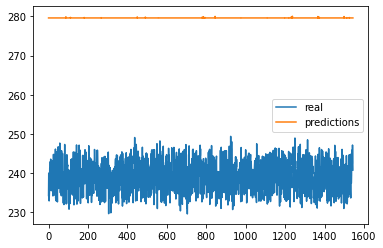

In [ ]:
errors = []
predictions = []
real = []
time = []
N = 1000
for idx, row in enumerate(df.values):
    x = row[1]
    x = time_to_seconds_since_midnight(x)
    u = torch.tensor([x], dtype=torch.float)
    y = row[4]

    y_pred = model(u)

    predictions.append(model(torch.tensor([y_pred], dtype=torch.float)).item())
    real.append(y)
    errors.append(predictions[-1] - real[-1])

    # if idx > 100:
    #     break

plt.plot(real, label='real')
plt.plot(predictions, label='predictions')
plt.legend()


(array([1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        3., 3., 1., 2., 0., 0., 2., 0., 0., 2., 0., 1., 1., 5., 1., 0., 0.,
        0., 2., 2., 1., 1., 1., 2., 3., 0., 0., 0., 0., 2., 0., 2., 1., 2.,
        1., 0., 0., 2., 1., 3., 3., 1., 3., 0., 1., 1., 2., 0., 0., 0., 3.,
        0., 0., 1., 1., 1., 0., 2., 2., 0., 3., 2., 1., 2., 0., 3., 1., 2.,
        3., 0., 0., 1., 0., 0., 1., 1., 0., 2., 1., 0., 1., 2., 1.]),
 array([31.93914185, 32.09604185, 32.25294185, 32.40984185, 32.56674185,
        32.72364185, 32.88054185, 33.03744185, 33.19434185, 33.35124185,
        33.50814185, 33.66504185, 33.82194185, 33.97884185, 34.13574185,
        34.29264185, 34.44954185, 34.60644185, 34.76334185, 34.92024185,
        35.07714185, 35.23404185, 35.39094185, 35.54784185, 35.70474185,
        35.86164185, 36.01854185, 36.17544185, 36.33234185, 36.48924185,
        36.64614185, 36.80304185, 36.95994185, 37.11684185, 37.27374185,
        37.43064185, 37.58754185, 37.74

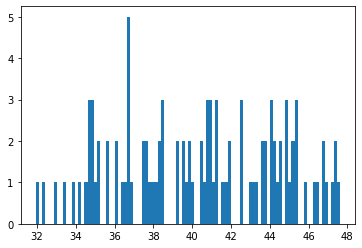

In [ ]:
plt.hist(errors, bins=100)